In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool

from scipy.optimize import leastsq
import scipy.stats as spst
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_statistics import *
from f_preprocessing import *
from fitting_functions_2000 import *

In [4]:
fol='/home/vanoorschot/work/fransje/confess_paper/'

In [5]:
from matplotlib.colors import LinearSegmentedColormap
# colors =['lightgrey','lightgrey','lightgrey']
# cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)
colors2 =['white','white','white']
cmap_white = LinearSegmentedColormap.from_list('cm',colors2, N=3)
colors =['gainsboro','none']
cmap_grey2 = LinearSegmentedColormap.from_list('cm',colors, N=2)
colors =['gainsboro','gainsboro','gainsboro']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)

In [6]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [7]:
cmap = cm.get_cmap('RdBu', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_list[11] = '#ffffff'
color_list[12] = '#ffffff'
cmap_rdbu = ListedColormap(color_list)

In [8]:
tl_0_1 = ['0.0','','0.2','','0.4','','0.6','','0.8','','1.0']
tl_0_2 = ['0.0','','0.04','','0.08','','0.12','','0.16','','0.2']
tl_02 = ['-0.20','','-0.12','','-0.04','','0.04','','0.12','','0.20']
tl_01 = ['-0.10','','-0.06','','-0.02','','0.02','','0.06','','0.10']
tl_800=['0','','160','','320','','480','','640','','800']
tl_500=['0','','100','','200','','300','','400','','500']
tl_1500=['0','','300','','600','','900','','1200','','1500']
tl_05=['0.0','','0.1','','0.2','','0.3','','0.4','','0.5']
tl_005=['-0.05','','-0.03','','-0.01','','0.01','','0.03','','0.05']
tl_003=['-0.03','','-0.0015','','0','','0.0015','','0.03']
tl_1 = ['-1.0','','-0.6','','-0.2','','0.2','','0.6','','1.0']

In [9]:
f_mod = f'{fol}/data/htessel_output/IAK5'
mod = xr.open_dataset(f'{f_mod}/o_veg_1999_2018_climatology.nc')
m = mod.var66.mean(dim='time')
mn = m.notnull()

## 1. FCOVER FITTING

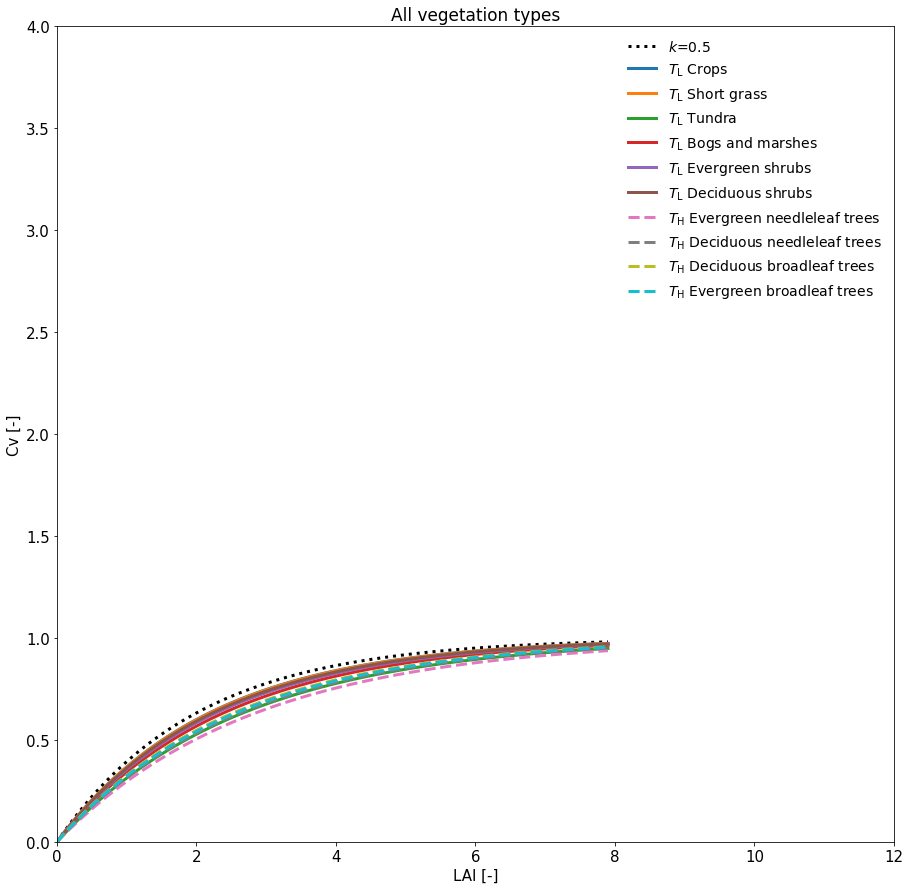

In [10]:
kval_l = [0.458,0.456,0.375,0.419,0.438,0.448]
kval_h = [0.351,0.381,0.396,0.390]
lai = np.arange(0,8,0.1)

def exp(k,lai):
    f = 1 - np.exp(-k*lai)
    return f    

farl = np.zeros((len(kval_l),len(lai)))
for k in range(len(kval_l)):
    f = exp(kval_l[k],lai)
    farl[k,:] = f
    
farh = np.zeros((len(kval_h),len(lai)))
for k in range(len(kval_h)):
    f = exp(kval_h[k],lai)
    farh[k,:] = f
    
k05 = exp(0.5,lai)  

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

ax.plot(lai,k05,'k:', label='$k$=0.5',linewidth=3)

ax.plot(lai,farl[0], label='$T_\mathrm{L}$ Crops',linewidth=3)
ax.plot(lai,farl[1], label='$T_\mathrm{L}$ Short grass',linewidth=3)
ax.plot(lai,farl[2], label='$T_\mathrm{L}$ Tundra',linewidth=3)
ax.plot(lai,farl[3], label='$T_\mathrm{L}$ Bogs and marshes',linewidth=3)
ax.plot(lai,farl[4], label='$T_\mathrm{L}$ Evergreen shrubs',linewidth=3)
ax.plot(lai,farl[5], label='$T_\mathrm{L}$ Deciduous shrubs',linewidth=3)

ax.plot(lai,farh[0],'--', label='$T_\mathrm{H}$ Evergreen needleleaf trees',linewidth=3)
ax.plot(lai,farh[1],'--', label='$T_\mathrm{H}$ Deciduous needleleaf trees',linewidth=3)
ax.plot(lai,farh[2],'--', label='$T_\mathrm{H}$ Deciduous broadleaf trees',linewidth=3)
ax.plot(lai,farh[3],'--', label='$T_\mathrm{H}$ Evergreen broadleaf trees',linewidth=3)

ax.set_xlim(0,12)
ax.set_ylim(0,4)
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel('LAI [-]',size=15)
ax.set_ylabel('Cv [-]',size=15)
ax.set_title('All vegetation types', fontsize=17)
ax.legend(ncol=1, fontsize=14, frameon=False)
fig.savefig(f'{fol}/output_figures/effective_cover/fitting_allvegtypes.jpg',dpi=300,bbox_inches='tight')


In [11]:
def veg_types(vt):
    if (vt==1):
        l = '$T_\mathrm{L}$ Crops'
    if (vt==2):
        l = '$T_\mathrm{L}$ Short grass'
    if (vt==3):
        l = '$T_\mathrm{H}$ EN trees'
    if (vt==4):
        l = '$T_\mathrm{H}$ DN trees'
    if (vt==5):
        l = '$T_\mathrm{H}$ DB trees'
    if (vt==6):
        l = '$T_\mathrm{H}$ EB trees'
    if (vt==9):
        l = '$T_\mathrm{L}$ Tundra'
    if (vt==13):
        l = '$T_\mathrm{L}$ Bogs and marshes'
    if (vt==16):
        l = '$T_\mathrm{L}$ E shrubs'
    if (vt==17):
        l = '$T_\mathrm{L}$ D shrubs'
    return l

In [12]:
def get_data(vt_l,th_l,i,year_start,year_end):
    vt = vt_l[i]
    th = th_l[i]
    xdata= np.load(f'{fold}/x_{year_start}_{year_end}_{vt}_{th}.npy')
    ydata= np.load(f'{fold}/y_{year_start}_{year_end}_{vt}_{th}.npy') 
    
    a = fitting(xdata,ydata)
    x = xdata
    y = ydata
    
    x_fitted = a[2]
    y_fitted = a[3]
    pval = a[4]
    par = a[5]
    rmse = a[6]
    
    xline = x_fitted
    yline = y_fitted
    k_opt = par[0]
    l = veg_types(vt)
    ar = np.arange(0,len(xdata),1)
    idx = np.random.choice(ar,5000, replace=False)
    xd = xdata[idx]
    yd = ydata[idx]
    
    # get rmse of k=0.5 vs fcover datapoints
    y5 = exp(xdata,0.5)
    y5fitted = exp(x_fitted,0.5)
    rmse5 = np.sqrt(np.mean((ydata-y5)**2))

    # calculate point density
    xy = np.vstack([xd,yd])
    z = gaussian_kde(xy)(xy)
    return xd,yd,z,x_fitted,y_fitted,k_opt,rmse,l,y5fitted,rmse5

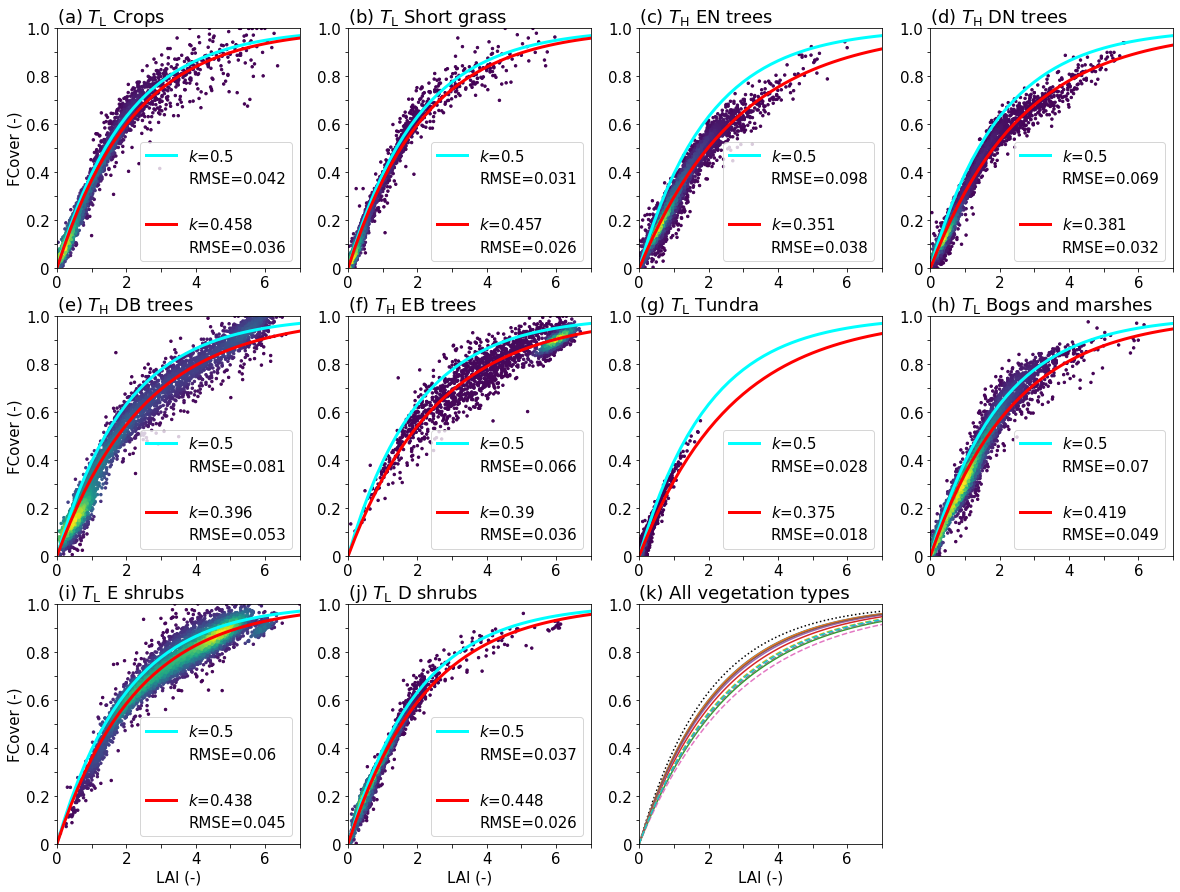

In [13]:
fold=f'{fol}/data/eff_cover_fitting/fitting_arrays/'
year_l = [1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
vt_l = [1,2,3,4,5,6,9,13,16,17]
th_l = ['0.90','0.90','0.85','0.75','0.70','0.90','0.90','0.75','0.70','0.70']
year_start = year_l[0]
year_end = year_l[-1]

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(341)
a = get_data(vt_l,th_l,0,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(a) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(342)
a = get_data(vt_l,th_l,1,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
# ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(b) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(343)
a = get_data(vt_l,th_l,2,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
# ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(c) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(344)
a = get_data(vt_l,th_l,3,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
# ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(d) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(345)
a = get_data(vt_l,th_l,4,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(e) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(346)
a = get_data(vt_l,th_l,5,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
# ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(f) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(347)
a = get_data(vt_l,th_l,6,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
# ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(g) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(348)
a = get_data(vt_l,th_l,7,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
# ax.set_xlabel('LAI (-)',size=15)
# ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(h) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(349)
a = get_data(vt_l,th_l,8,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
ax.set_xlabel('LAI (-)',size=15)
ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(i) {a[7]}', fontsize=18,loc='left')

ax = fig.add_subplot(3,4,10)
a = get_data(vt_l,th_l,9,year_start,year_end)
ax.scatter(a[0],a[1],c=a[2],s=6)
ax.plot(a[3],a[8],'-',color='cyan',linewidth=3,label=f'$k$=0.5')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[9],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label='   ')
ax.plot(a[3],a[4],'-r',linewidth=3,label=f'$k$={np.round(a[5],3)}')
ax.plot([0.8,0.8],[0.9,0.9],'-',color='white',label=f'RMSE={np.round(a[6],3)}')
ax.legend(ncol=1,loc='lower right',fontsize=15)
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(labelsize=15)
ax.set_xlabel('LAI (-)',size=15)
# ax.set_ylabel('FCover (-)',size=15)
ax.set_title(f'(j) {a[7]}', fontsize=18,loc='left')

kval_l = [0.458,0.456,0.375,0.419,0.438,0.448]
kval_h = [0.351,0.381,0.396,0.390]
lai = np.arange(0,8,0.1)

def exp(k,lai):
    f = 1 - np.exp(-k*lai)
    return f    

farl = np.zeros((len(kval_l),len(lai)))
for k in range(len(kval_l)):
    f = exp(kval_l[k],lai)
    farl[k,:] = f
    
farh = np.zeros((len(kval_h),len(lai)))
for k in range(len(kval_h)):
    f = exp(kval_h[k],lai)
    farh[k,:] = f
    
k05 = exp(0.5,lai)  

ax = fig.add_subplot(3,4,11)
ax.plot(lai,k05,'k:', label='k=0.5')
ax.plot(lai,farl[0], label='TVL1 Crops')
ax.plot(lai,farl[1], label='TVL2 Short grass')
ax.plot(lai,farl[2], label='TVL9 Tundra')
ax.plot(lai,farl[3], label='TVL13 Bogs and marshes')
ax.plot(lai,farl[4], label='TVL16 Evergreen shrubs')
ax.plot(lai,farl[5], label='TVL17 Deciduous shrubs')
ax.plot(lai,farh[0],'--', label='TVH3 Evergreen needleleaf trees')
ax.plot(lai,farh[1],'--', label='TVH4 Deciduous needleleaf trees')
ax.plot(lai,farh[2],'--', label='TVH5 Deciduous broadleaf trees')
ax.plot(lai,farh[3],'--', label='TVH6 Evergreen broadleaf trees')
ax.set_xlim(0,7)
ax.set_ylim(0,1)
ax.set_xticklabels(['0','','2','','4','','6',''])
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(axis='both',labelsize=15)
ax.set_xlabel('LAI (-)',size=15)
ax.set_title('(k) All vegetation types', fontsize=18,loc='left')

fig.savefig(f'{fol}/output_figures/effective_cover/fit_{year_start}_{year_end}_allvegtypes.jpg',dpi=300,bbox_inches='tight')

## exp5 vs exp6

In [14]:
exp_name1='exp5'
exp_name2='exp6'
name1='IAK5'
name2='IAKV'
start_year=1999
end_year=2018

## FCOVER - all months

In [15]:
# all months
name1='IAK5'
name2='IAKV'

# exp5
f_mod = f'{fol}/data/htessel_output/{name1}'
d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_monthly.nc')
cvl = d.CVL[:]
cvh = d.CVH[:] 
cv1 = cvl+cvh
cv1m = cv1.mean(dim='time')

# exp6
f_mod = f'{fol}/data/htessel_output/{name2}'
d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_monthly.nc')
cvl = d.CVL[:]
cvh = d.CVH[:] 
cv2 = cvl+cvh
cv2m = cv2.mean(dim='time')

# reldiff
cv_c = (cv2m-cv1m)/cv1m
cv_ca = (cv2m-cv1m)


# rmse
f = xr.open_dataset(f'{fol}/data/eff_cover_fitting/mergetime_fcover_n128_1999_2019_monmean_settime.nc')
fc = f.FCOVER[:] 

er2 = (cv1 - fc)**2
rmse1 = np.sqrt(er2.mean(dim=['time'])) 
er2 = (cv2 - fc)**2
rmse2 = np.sqrt(er2.mean(dim=['time']))  
rmse = rmse1 - rmse2

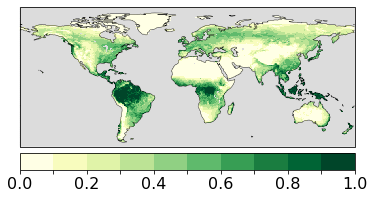

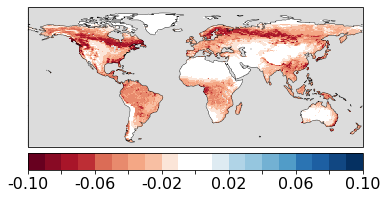

In [16]:
# all months
rmse = rmse.where(cv_c)
cv1m = cv1m.where(cv_c)

cmapy = plt.cm.get_cmap('YlGn')
n = cv_c.notnull()
# cmap.set_bad('gainsboro',alpha=0.3)
lvls= np.linspace(0,1,11)
lvls2= np.linspace(0,1,11)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cv1m.plot(ax=ax, cmap=cmapy, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'',size=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/fcover_mean_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

# rel diff
n = cv_c.notnull()
# cmap = plt.cm.get_cmap('RdYlBu')
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
# cv_ca[0,0] = 0.3 # fix colorbar
# cv_ca[0,1] = -0.3 # fix colorbar
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cv_ca.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2,extend='neither')
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_01)
ax.set_title(f'',size=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/fcover_mean_absdiff_{start_year}_{end_year}_{exp_name2}-{exp_name1}_{name2}-{name1}.jpg',dpi=300,bbox_inches='tight')

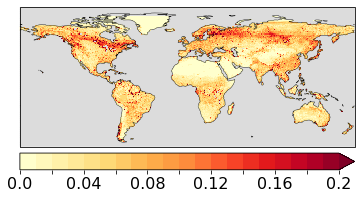

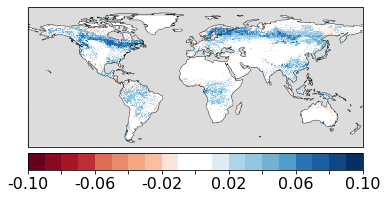

In [17]:
# RMSE
cmap = cmap_map(lambda x: x/1.1, cm.jet_r)
n = cv_c.notnull()
cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0,0.2,21)
lvls2= np.linspace(0,0.2,11)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_2)
ax.set_title(f'',size=16)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/fcover_rmse1_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

n = cv_c.notnull()
# cmap = plt.cm.get_cmap('RdYlBu')
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmse.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_01)
ax.set_title(f'',size=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/fcover_rmsedif_{start_year}_{end_year}_{exp_name2}-{exp_name1}_{name2}-{name1}.jpg',dpi=300,bbox_inches='tight')


### FCOVER - seasons

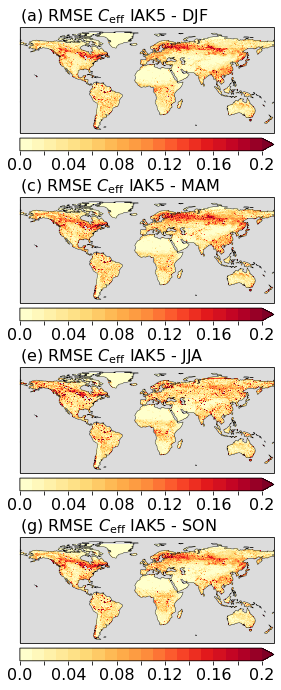

In [18]:
fig = plt.figure(figsize=(24,10))
cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0,0.2,21)
lvls2= np.linspace(0,0.2,11)
seasons = ['djf','mam','jja','son']
seasons_up = ['DJF','MAM','JJA','SON']
al = ['a','c','e','g']

for i in range(len(seasons)):
    name1='IAK5'
    name2='IAKV'

    # exp5
    f_mod = f'{fol}/data/htessel_output/{name1}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv1 = cvl+cvh
    cv1m = cv1.mean(dim='time')

    # exp6
    f_mod = f'{fol}/data/htessel_output/{name2}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv2 = cvl+cvh
    cv2m = cv2.mean(dim='time')

    # reldiff
    cv_c = (cv2m-cv1m)/cv1m

    # rmse
    f = xr.open_dataset(f'{fol}/data/eff_cover_fitting/mergetime_fcover_n128_1999_2019_monmean_settime_fullfield_{seasons[i]}.nc')
    fc = f.FCOVER[:] 

    er2 = (cv1 - fc)**2
    rmse1 = np.sqrt(er2.mean(dim=['time'])) 
    er2 = (cv2 - fc)**2
    rmse2 = np.sqrt(er2.mean(dim=['time']))  
    rmse = rmse1 - rmse2
    
    # all months
    n = cv_c.notnull()
    ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree())
    plt.subplots_adjust(left=0.01,
                    bottom=0.01,
                    right=0.5,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.3)
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,shrink=0.3)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_xticklabels(tl_0_2)
    # ax.set_title(f'({al[i]}) {seasons_up[i]} FCover RMSE {name1}',size=16,loc='left')
    ax.set_title('('+str(al[i])+') RMSE $C_\mathrm{eff}$ '+str(name1)+' - '+str(seasons_up[i]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)

fig.savefig(f'{fol}/output_figures/effective_cover/fcover_rmse_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')


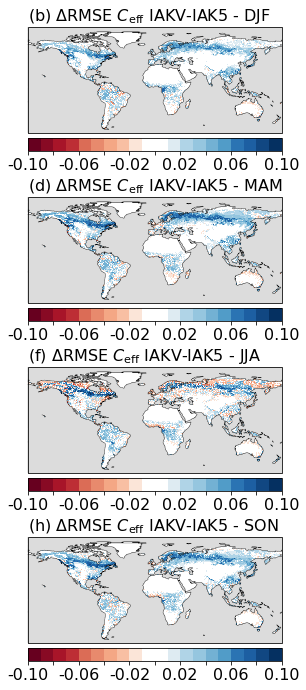

In [19]:
fig = plt.figure(figsize=(24,10))
lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
seasons = ['djf','mam','jja','son']
seasons_up = ['DJF','MAM','JJA','SON']
al = ['b','d','f','h']

for i in range(len(seasons)):
    name1='IAK5'
    name2='IAKV'

    # exp5
    f_mod = f'{fol}/data/htessel_output/{name1}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    # d = d.where(fc) # make sure same points used
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv1 = cvl+cvh
    cv1m = cv1.mean(dim='time')

    # exp6
    f_mod = f'{fol}/data/htessel_output/{name2}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    # d = d.where(fc) # make sure same points used
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv2 = cvl+cvh
    cv2m = cv2.mean(dim='time')

    # reldiff
    cv_c = (cv2m-cv1m)/cv1m

    # rmse
    f = xr.open_dataset(f'{fol}/data/eff_cover_fitting/mergetime_fcover_n128_1999_2019_monmean_settime_fullfield_{seasons[i]}.nc')
    fc = f.FCOVER[:] 

    er2 = (cv1 - fc)**2
    rmse1 = np.sqrt(er2.mean(dim=['time'])) 
    er2 = (cv2 - fc)**2
    rmse2 = np.sqrt(er2.mean(dim=['time']))  
    rmse = rmse1 - rmse2
    
    # all months
    n = cv_c.notnull()
    ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree())
    plt.subplots_adjust(left=0.01,
                    bottom=0.01,
                    right=0.5,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.3)
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,shrink=0.3)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_xticklabels(tl_01)
    ax.set_title('('+str(al[i])+') $\Delta$RMSE $C_\mathrm{eff}$ '+str(name2)+'-'+str(name1)+' - '+str(seasons_up[i]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/fcover_rmsediff_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}.jpg',dpi=300,bbox_inches='tight')


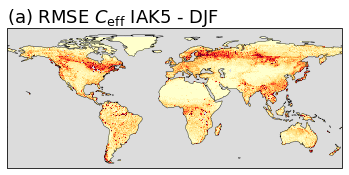

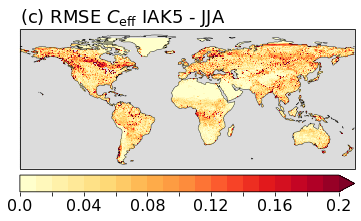

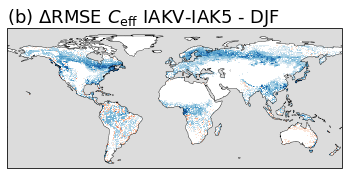

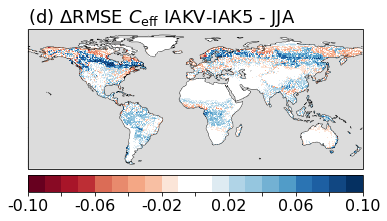

In [20]:
# JJA AND DJF

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0,0.2,21)
lvls2= np.linspace(0,0.2,11)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','c','e','g']

for i in range(len(seasons)):
    name1='IAK5'
    name2='IAKV'

    # exp5
    f_mod = f'{fol}/data/htessel_output/{name1}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    # d = d.where(fc) # make sure same points used
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv1 = cvl+cvh
    cv1m = cv1.mean(dim='time')

    # exp6
    f_mod = f'{fol}/data/htessel_output/{name2}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    # d = d.where(fc) # make sure same points used
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv2 = cvl+cvh
    cv2m = cv2.mean(dim='time')

    # reldiff
    cv_c = (cv2m-cv1m)/cv1m

    # rmse
    f = xr.open_dataset(f'{fol}/data/eff_cover_fitting/mergetime_fcover_n128_1999_2019_monmean_settime_fullfield_{seasons[i]}.nc')
    fc = f.FCOVER[:] 

    er2 = (cv1 - fc)**2
    rmse1 = np.sqrt(er2.mean(dim=['time'])) 
    er2 = (cv2 - fc)**2
    rmse2 = np.sqrt(er2.mean(dim=['time']))  
    rmse = rmse1 - rmse2
    
    # all months
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    n = cv_c.notnull()
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    if (i==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_xticklabels(tl_0_2)
    ax.set_title('('+str(al[i])+') RMSE $C_\mathrm{eff}$ '+str(name1)+' - '+str(seasons_up[i]),size=18,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/effective_cover/fcover_rmse_{start_year}_{end_year}_{exp_name1}_{name1}_{seasons_up[i]}.jpg',dpi=300,bbox_inches='tight')

lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)
al = ['b','d','f','h']

for i in range(len(seasons)):
    name1='IAK5'
    name2='IAKV'

    # exp5
    f_mod = f'{fol}/data/htessel_output/{name1}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    # d = d.where(fc) # make sure same points used
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv1 = cvl+cvh
    cv1m = cv1.mean(dim='time')

    # exp6
    f_mod = f'{fol}/data/htessel_output/{name2}'
    d = xr.open_dataset(f'{f_mod}/o_veg_{start_year}_{end_year}_{seasons[i]}.nc')
    # d = d.where(fc) # make sure same points used
    cvl = d.CVL[:]
    cvh = d.CVH[:] 
    cv2 = cvl+cvh
    cv2m = cv2.mean(dim='time')

    # reldiff
    cv_c = (cv2m-cv1m)/cv1m

    # rmse
    f = xr.open_dataset(f'{fol}/data/eff_cover_fitting/mergetime_fcover_n128_1999_2019_monmean_settime_fullfield_{seasons[i]}.nc')
    fc = f.FCOVER[:] 

    er2 = (cv1 - fc)**2
    rmse1 = np.sqrt(er2.mean(dim=['time'])) 
    er2 = (cv2 - fc)**2
    rmse2 = np.sqrt(er2.mean(dim=['time']))  
    rmse = rmse1 - rmse2
    
    # all months
    n = cv_c.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    if (i==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_xticklabels(tl_01)
    ax.set_title('('+str(al[i])+') $\Delta$RMSE $C_\mathrm{eff}$ '+str(name2)+'-'+str(name1)+' - '+str(seasons_up[i]),size=18,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/effective_cover/fcover_rmsediff_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_{seasons_up[i]}.jpg',dpi=300,bbox_inches='tight')



### EVAPORATION - all months

In [21]:
from matplotlib import cm

In [22]:
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
name1='IAK5'
name2='IAKV'
rel=f'({name2}-{name1})/{name1}'

et1 = mod1.TVEG * -1000
es1 = mod1.ESOIL * -1000
e1 = mod1.E * -1000
ei1 = mod1.evatc * -1000

et2 = mod2.TVEG * -1000
es2 = mod2.ESOIL * -1000
e2 = mod2.E * -1000
ei2 = mod2.evatc * -1000

etm1 = et1.mean(dim='time')*365
esm1 = es1.mean(dim='time')*365
eim1 = ei1.mean(dim='time')*365
em1 = e1.mean(dim='time')*365

etm2 = et2.mean(dim='time')*365
esm2 = es2.mean(dim='time')*365
eim2 = ei2.mean(dim='time')*365
em2 = e2.mean(dim='time')*365

etm1 = etm1.where(etm1>0.1)
esm1 = esm1.where(esm1>0.1)
eim1 = eim1.where(eim1>0.1)
em1 = em1.where(em1>0.1)

etmask = etm1.where(etm1>0.1)
esmask = esm1.where(esm1>0.1)
eimask = eim1.where(eim1>0.1)
emask = em1.where(em1>0.1)

et_c = (etm2-etm1)/etm1
es_c = (esm2-esm1)/esm1
ei_c = (eim2-eim1)/eim1
e_c = (em2-em1)/em1

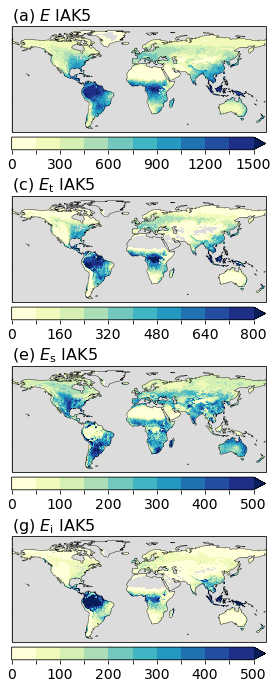

In [23]:
# PLOT MEAN EVAPORATION FLUXES

cmap = plt.cm.get_cmap('YlGnBu')

lvls= np.linspace(0,1500,11)
lvls2= np.linspace(0,1500,11)
fig = plt.figure(figsize=(24,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = em1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(a) $E$ '+str(name1),size=16, loc='left')
cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,800,11)
lvls2= np.linspace(0,800,11)
n = etm1.notnull()
ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = etm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(c) $E_{\mathrm{t}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_800)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = esm1.notnull()
ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = esm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(e) $E_{\mathrm{s}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = eim1.notnull()
ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = eim1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.3)
cbar.ax.tick_params(labelsize=14)
ax.set_title('(g) $E_{\mathrm{i}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/e_mean_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

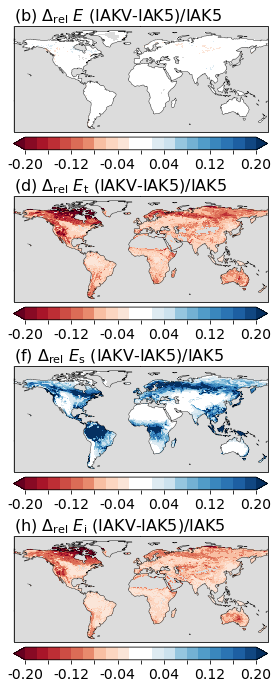

In [24]:
# plot relative difference E IAKV vs IAK5

# cmap = plt.cm.get_cmap('RdYlBu')
lvls= np.linspace(-0.2,0.2,21)
lvls2= np.linspace(-0.2,0.2,11)

fig = plt.figure(figsize=(24,10))
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
ax.coastlines(linewidth=0.4)
n = e_c.notnull()
e_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = e_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_02)
ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $E$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = et_c.notnull()
et_c[0,0]=0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = et_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_02)
ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{t}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = es_c.notnull()
es_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = es_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_02)
ax.set_title('(f) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{s}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ei_c[0,0]=0.21
n = ei_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ei_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.3)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_02)
ax.set_title('(h) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{i}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/e_mean_{start_year}_{end_year}_reldiff_{exp_name2}-{exp_name1}_{name2}-{name1}.jpg',dpi=300,bbox_inches='tight')

### EVAPORATION - global mean values

In [25]:
mod = xr.open_dataset(f'{f_mod}/o_wat_{start_year}_{end_year}_monthly.nc')
c_et = iris.load_cube(f'{f_mod}/o_wat_{start_year}_{end_year}_monthly.nc','TVEG')
c_es = iris.load_cube(f'{f_mod}/o_wat_{start_year}_{end_year}_monthly.nc','ESOIL')
c_ei = iris.load_cube(f'{f_mod}/o_wat_{start_year}_{end_year}_monthly.nc','evatc')
c_e = iris.load_cube(f'{f_mod}/o_wat_{start_year}_{end_year}_monthly.nc','E')
c_p = iris.load_cube(f'{f_mod}/o_wat_{start_year}_{end_year}_monthly.nc','TP')
c_q = iris.load_cube(f'{f_mod}/o_wat_{start_year}_{end_year}_monthly.nc','RO')

c_et.coord('latitude').guess_bounds()
c_et.coord('longitude').guess_bounds()
grid_areas = iris.analysis.cartography.area_weights(c_et)

c_etm = c_et.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
c_esm = c_es.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
c_eim = c_ei.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
c_e = c_e.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
c_p = c_p.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
c_q = c_q.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)

etm1 = xr.DataArray.from_iris(c_etm) * -1000
esm1 = xr.DataArray.from_iris(c_esm) * -1000
eim1 = xr.DataArray.from_iris(c_eim) * -1000
em1= xr.DataArray.from_iris(c_e) * -1000
pm1 = xr.DataArray.from_iris(c_p) * 1000
qm1 = xr.DataArray.from_iris(c_q) * 1000

In [26]:
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
name1='IAK5'
name2='IAKV'

et1 = iris.load_cube(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc','TVEG')
es1 = iris.load_cube(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc','ESOIL')
ei1 = iris.load_cube(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc','evatc')
e1 = iris.load_cube(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc','E')

et1.coord('latitude').guess_bounds()
et1.coord('longitude').guess_bounds()
grid_areas = iris.analysis.cartography.area_weights(et1)
etm1 = et1.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
esm1 = es1.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
eim1 = ei1.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
em1 = e1.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)

etm1 = xr.DataArray.from_iris(etm1) * -1000
esm1 = xr.DataArray.from_iris(esm1) * -1000
eim1 = xr.DataArray.from_iris(eim1) * -1000
em1= xr.DataArray.from_iris(em1) * -1000

etm1g = etm1.mean(dim='time').values * 365
esm1g = esm1.mean(dim='time').values * 365
eim1g = eim1.mean(dim='time').values * 365
em1g = em1.mean(dim='time').values * 365

et2 = iris.load_cube(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc','TVEG')
es2 = iris.load_cube(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc','ESOIL')
ei2 = iris.load_cube(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc','evatc')
e2 = iris.load_cube(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc','E')

et2.coord('latitude').guess_bounds()
et2.coord('longitude').guess_bounds()
grid_areas = iris.analysis.cartography.area_weights(et2)
etm2 = et2.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
esm2 = es2.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
eim2 = ei2.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)
em2 = e2.collapsed(['longitude','latitude'], iris.analysis.MEAN, weights=grid_areas)

etm2 = xr.DataArray.from_iris(etm2) * -1000
esm2 = xr.DataArray.from_iris(esm2) * -1000
eim2 = xr.DataArray.from_iris(eim2) * -1000
em2= xr.DataArray.from_iris(em2) * -1000

etm2g = etm2.mean(dim='time').values * 365
esm2g = esm2.mean(dim='time').values * 365
eim2g = eim2.mean(dim='time').values * 365
em2g = em2.mean(dim='time').values * 365

etg_c = (etm2g-etm1g)/etm1g * 100
esg_c = (esm2g-esm1g)/esm1g * 100
eig_c = (eim2g-eim1g)/eim1g * 100
eg_c = (em2g-em1g)/em1g * 100

In [27]:
df = pd.DataFrame(index=[f'{name1}',f'{name2}','reldiff'],columns=['E','Et','Es','Ei'])
df.loc[f'{name1}'] = [int(em1g),int(etm1g),int(esm1g),int(eim1g)]
df.loc[f'{name2}'] = [int(em2g),int(etm2g),int(esm2g),int(eim2g)]
df.loc['reldiff'] = [np.round(eg_c,2),np.round(etg_c,2),np.round(esg_c,2),np.round(eig_c,2)]
df

,E,Et,Es,Ei
IAK5,481,192,181,100
IAKV,479,181,195,95
reldiff,-0.38,-5.59,7.5,-4.44


## SOIL MOISTURE - all months

In [28]:
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_monthly.nc')
name1='IAK5'
name2='IAKV'

sm11 = mod1.SWVL1 
sm12 = mod1.SWVL2 
sm13 = mod1.SWVL3 
sm14 = mod1.SWVL4 
sm1234 = mod1.SWVL234

sm21 = mod2.SWVL1
sm22 = mod2.SWVL2
sm23 = mod2.SWVL3
sm24 = mod2.SWVL4
sm2234 = mod2.SWVL234

sm11m = sm11.mean(dim='time')
sm12m = sm12.mean(dim='time')
sm13m = sm13.mean(dim='time')
sm14m = sm14.mean(dim='time')
sm1234m = sm1234.mean(dim='time')

sm11m = sm11m.where(sm11m>0.01)
sm12m = sm12m.where(sm12m>0.01)
sm13m = sm13m.where(sm13m>0.01)
sm14m = sm14m.where(sm14m>0.01)
sm1234m = sm1234m.where(sm1234m>0.01)

sm1_c = (sm21.mean(dim='time')-sm11m)/sm11m
sm2_c = (sm22.mean(dim='time')-sm12m)/sm12m
sm3_c = (sm23.mean(dim='time')-sm13m)/sm13m
sm4_c = (sm24.mean(dim='time')-sm14m)/sm14m
sm234_c = (sm2234.mean(dim='time')-sm1234m)/sm1234m

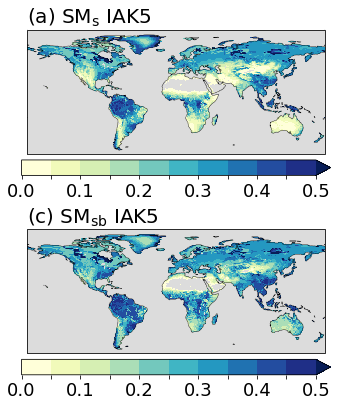

In [29]:
cmap = plt.cm.get_cmap('YlGnBu')
lvls= np.linspace(0,0.5,11)
lvls2= np.linspace(0,0.5,11)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.3)
ax.coastlines(linewidth=0.4)
n = sm11m.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm11m.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.73)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xticklabels(tl_05)
ax.set_title('(a) $\mathrm{SM}_{\mathrm{s}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sm1234m.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm1234m.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.73)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xticklabels(tl_05)
ax.set_title('(c) $\mathrm{SM}_{\mathrm{sb}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/sm_2_rel_mean_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

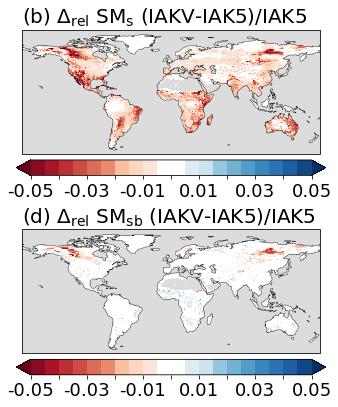

In [30]:
# cmap = plt.cm.get_cmap('RdBu')
lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.3)
ax.coastlines(linewidth=0.4)
n = sm1_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm1_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.73)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xticklabels(tl_005)
ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{s}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sm234_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm234_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.73)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xticklabels(tl_005)
ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{sb}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/sm_2_rel_mean_reldiff_{start_year}_{end_year}_{exp_name2}-{exp_name1}_{name2}-{name1}.jpg',dpi=300,bbox_inches='tight')

### RMSE evaporation

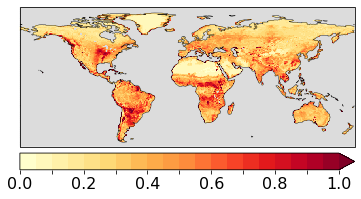

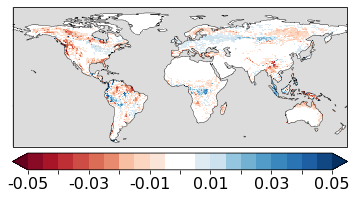

In [31]:
mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
e1 = mod.E * -1000

mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
e2 = mod.E * -1000

ref_data = 'DOLCE_v3'
fol_ref = f'{fol}/data/ref_data'
ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
ref = ref.hfls/28.94 # from w/m2 to mm/day

rmse1 = LE_rmse(e1,ref)
rmse2 = LE_rmse(e2,ref)
rmsed = rmse1-rmse2
rmsed[0,0]=-0.04

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0,1,21)
lvls2= np.linspace(0,1,11)
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
# ax.set_title('RMSE $E$ '+str(name1),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmse_e_monthly_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)
tl=['-0.03','','-0.0018','','-0.006','','0.006','','0.0018','','0.03']
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_005)
# ax.set_title('$\Delta$RMSE $E$ '+str(name1)+'-'+str(name2),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_e_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}.jpg',dpi=300,bbox_inches='tight')

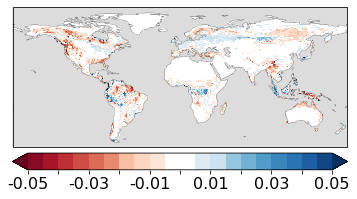

In [32]:
# plot rmse diff with with significance test
ref_data = 'DOLCE_v3'
start_year = '1999'
end_year = '2018'
var = 'hfls'
reps = 1000
tp = 'fullfield'
dt = 'dt_no'
#load quantiles
tp2 = tp.replace(" ", "_")
q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{ref_data}_{start_year}_{end_year}_rmse_{dt}_allmonths.nc')


mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
e1 = mod.E * -1000

mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
e2 = mod.E * -1000

ref_data = 'DOLCE_v3'
fol_ref = f'{fol}/data/ref_data'
ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
ref = ref.hfls/28.94 # from w/m2 to mm/day

r1 = LE_rmse(e1,ref)
r2 = LE_rmse(e2,ref)
r = rmse1-rmse2
r[0,0]=-0.04

# calculate area percentages of results
cube = r.to_iris()
cube.coord('latitude').guess_bounds()
cube.coord('longitude').guess_bounds()
grid_areas = iris.analysis.cartography.area_weights(cube)

# without significance
r = r.where(r.lat>-60) # exclude antarctica
areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
areas = areas.where(areas.lat>-60) # exclude antarctica
a = areas.where(r.notnull()) # all land points areas with data
asum = a.sum().values # total land area with data

ap = areas.where(r>0) # positive correlation diff - improvement
an = areas.where(r<0) # negative correlation diff - deterioration
ap_p = ap.sum().values/a.sum().values # percentage of +
an_p = an.sum().values/a.sum().values # percentage of -

# with significance
rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
areas = areas.where(areas.lat>-60) # exclude antarctica
a = areas.where(r.notnull()) # all land points areas with data
asum = a.sum().values # total land area with data

asig = areas.where(rs2.notnull()) # all land points areas with data
asigsum = asig.sum().values # total land area with data
asigp = asigsum/asum
aps = areas.where(rs2>0) # positive correlation diff - improvement
ans = areas.where(rs2<0) # negative correlation diff - deterioration
aps_p = aps.sum().values/a.sum().values # percentage of +
ans_p = ans.sum().values/a.sum().values # percentage of -
aps_ps = aps.sum().values/asig.sum().values # percentage of +
ans_ps = ans.sum().values/asig.sum().values # percentage of -

# mean + or - delta correlation
rp = r.where(r>0).mean().values
rn = r.where(r<0).mean().values

rps = rs2.where(rs2>0).mean().values
rns = rs2.where(rs2<0).mean().values

rnull = r.isnull()

lvls = np.linspace(-0.05,0.05,21)
lvls3 = np.linspace(-0.05,0.05,11)
lvls2 = np.linspace(-0.05,0.05,2) 
cm2 = plt.cm.get_cmap('Pastel2_r')

# fig with stats
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
n = r.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_005)
ax.set_title(f'',size=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

# ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=10)
# ax.annotate(f'+ $\Delta$RMSE sig: {np.int(aps_ps*100)}%',(-177,-38), size=10)
# ax.annotate(f'- $\Delta$RMSE sig: {np.int(ans_ps*100)}%',(-177,-55),size=10)

fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_e_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_sig.jpg',dpi=300,bbox_inches='tight')

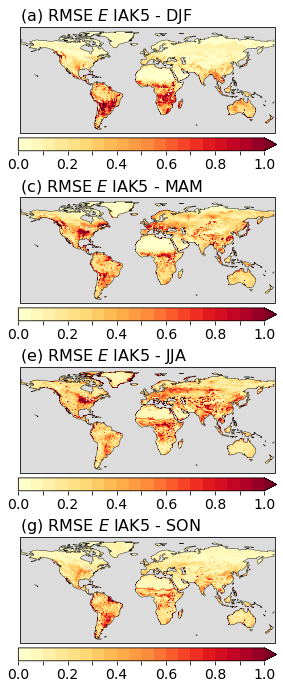

In [33]:
al = ['a','c','e','g']
seasons2=['DJF','MAM','JJA','SON']

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0,1,21)
lvls2= np.linspace(0,1,11)

fig = plt.figure(figsize=(24,10))
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
seasons=['djf','mam','jja','son']
for j in range(len(seasons)):
    mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_{seasons[j]}.nc')
    e1 = mod.E * -1000
    mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_{seasons[j]}.nc')
    e2 = mod.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_fullfield_{seasons[j]}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    rmse1 = LE_rmse(e1,ref)
    rmse2 = LE_rmse(e2,ref)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
    
    ax = plt.subplot(4,1,j+1,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    n = rmsed.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,shrink=0.305)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_0_1)
    ax.set_title('('+str(al[j])+') RMSE $E$ '+str(name1)+' - '+str(seasons2[j]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmse_e_monthly_{start_year}_{end_year}_{exp_name1}_{name1}_seasons.jpg',dpi=300,bbox_inches='tight')

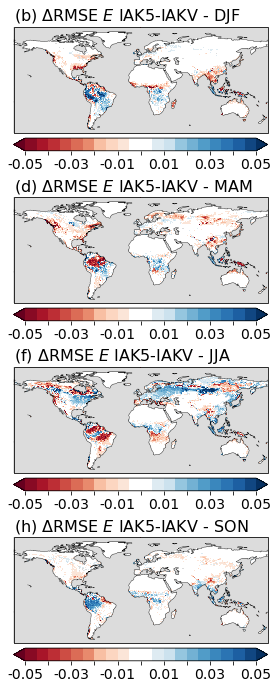

In [34]:
al = ['b','d','f','h']
seasons2=['DJF','MAM','JJA','SON']
seasons=['djf','mam','jja','son']
lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)

fig = plt.figure(figsize=(24,10))
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
for j in range(len(seasons)):
    mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_{seasons[j]}.nc')
    e1 = mod.E * -1000
    mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_{seasons[j]}.nc')
    e2 = mod.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_fullfield_{seasons[j]}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    rmse1 = LE_rmse(e1,ref)
    rmse2 = LE_rmse(e2,ref)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
    
    ax = plt.subplot(4,1,j+1,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    n = rmsed.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,shrink=0.3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_005)
    ax.set_title('('+str(al[j])+') $\Delta$RMSE $E$ '+str(name1)+'-'+str(name2)+' - '+str(seasons2[j]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_e_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_seasons.jpg',dpi=300,bbox_inches='tight')

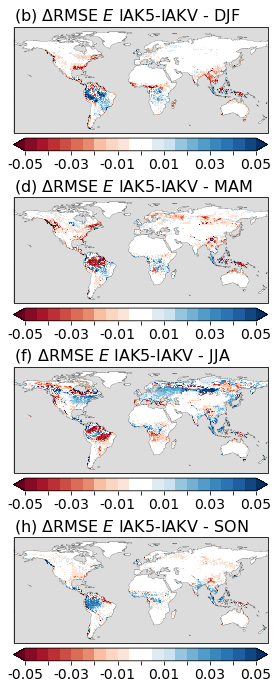

In [35]:
# rmse seasons with sig
al = ['b','d','f','h']
seasons2=['DJF','MAM','JJA','SON']

lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)

fig = plt.figure(figsize=(24,10))
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
seasons=['djf','mam','jja','son']
for j in range(len(seasons)):
    ref_data = 'DOLCE_v3'
    start_year = '1999'
    end_year = '2018'
    var = 'hfls'
    season=seasons[j]
    reps = 1000
    tp = 'fullfield'
    dt = 'dt_no'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{season}_{ref_data}_{start_year}_{end_year}_rmse_{dt}.nc')
    
    mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_{seasons[j]}.nc')
    e1 = mod.E * -1000
    mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_{seasons[j]}.nc')
    e2 = mod.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_fullfield_{seasons[j]}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    r1 = LE_rmse(e1,ref)
    r2 = LE_rmse(e2,ref)
    r = r1-r2
    r[0,0]=-0.04

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()

    lvls= np.linspace(-0.05,0.05,21)
    lvls2= np.linspace(-0.05,0.05,11)
    cm2 = plt.cm.get_cmap('Pastel2_r')
    
    ax = plt.subplot(4,1,j+1,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    n = r.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,shrink=0.3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_005)
    ax.set_title('('+str(al[j])+') $\Delta$RMSE $E$ '+str(name1)+'-'+str(name2)+' - '+str(seasons2[j]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)

    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=8)
    # ax.annotate(f'+ $\Delta$RMSE sig: {np.int(aps_ps*100)}%',(-177,-38), size=8)
    # ax.annotate(f'- $\Delta$RMSE sig: {np.int(ans_ps*100)}%',(-177,-55),size=8)

fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_e_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_seasons_sig.jpg',dpi=300,bbox_inches='tight')

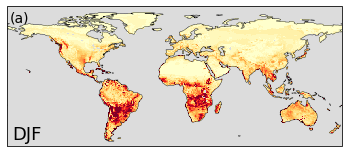

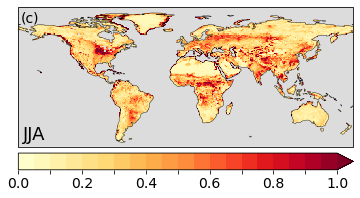

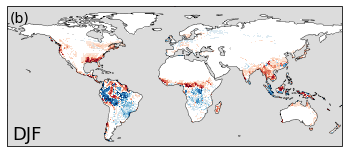

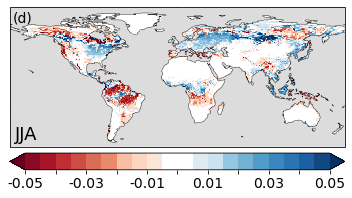

In [36]:
#JJA AND DJF
# JJA AND DJF

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0,1,21)
lvls2= np.linspace(0,1,11)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','c','e','g']

for i in range(len(seasons)):
    name1='IAK5'
    name2='IAKV'

    mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_{seasons[i]}.nc')
    e1 = mod.E * -1000
    mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_{seasons[i]}.nc')
    e2 = mod.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_fullfield_{seasons[i]}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    rmse1 = LE_rmse(e1,ref)
    rmse2 = LE_rmse(e2,ref)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
    
    # all months
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    n = rmsed.notnull()
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    if (i==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_0_1)
    ax.annotate(f'({al[i]})',(-177,74),size=14)
    # ax.annotate(f'{seasons_up[i]}',(148,71),size=18)
    ax.annotate(f'{seasons_up[i]}',(-175,-53),size=18)
    # ax.set_title('('+str(al[i])+') RMSE $E$ '+str(name1)+' - '+str(seasons_up[i]),size=18,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/effective_cover/rmse_e_monthly_{start_year}_{end_year}_{exp_name1}_{name1}_{seasons_up[i]}.jpg',dpi=300,bbox_inches='tight')

lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)
al = ['b','d','f','h']

for i in range(len(seasons)):
    name1='IAK5'
    name2='IAKV'
    
    mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_{seasons[i]}.nc')
    e1 = mod.E * -1000
    mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_{seasons[i]}.nc')
    e2 = mod.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_fullfield_{seasons[i]}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    rmse1 = LE_rmse(e1,ref)
    rmse2 = LE_rmse(e2,ref)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
    
    # all months
    n = rmsed.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    if (i==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_005)
    ax.annotate(f'({al[i]})',(-177,74),size=14)
    # ax.annotate(f'{seasons_up[i]}',(148,71),size=18)
    ax.annotate(f'{seasons_up[i]}',(-175,-53),size=18)
    # ax.set_title('('+str(al[i])+') $\Delta$RMSE $E$ '+str(name2)+'-'+str(name1)+' - '+str(seasons_up[i]),size=18,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_e_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_{seasons_up[i]}.jpg',dpi=300,bbox_inches='tight')


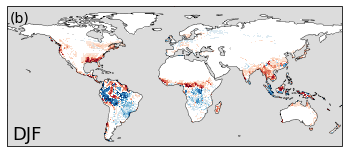

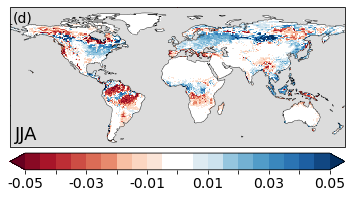

In [37]:
# JJA DJF DIFF SIG
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)
al = ['b','d']

for i in range(len(seasons)):
    ref_data = 'DOLCE_v3'
    start_year = '1999'
    end_year = '2018'
    var = 'hfls'
    season=seasons[i]
    reps = 1000
    tp = 'fullfield'
    dt = 'dt_no'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{season}_{ref_data}_{start_year}_{end_year}_rmse_{dt}.nc')
    
    name1='IAK5'
    name2='IAKV'
    
    mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_{seasons[i]}.nc')
    e1 = mod.E * -1000
    mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_{seasons[i]}.nc')
    e2 = mod.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_fullfield_{seasons[i]}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    r1 = LE_rmse(e1,ref)
    r2 = LE_rmse(e2,ref)
    r = r1-r2
    r[0,0]=-0.04

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()
    
    # all months
    n = rmsed.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (i==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_005)
    # ax.set_title('('+str(al[i])+') $\Delta$RMSE $E$ '+str(name2)+'-'+str(name1)+' - '+str(seasons_up[i]),size=18,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    ax.annotate(f'({al[i]})',(-177,74),size=14)
    # ax.annotate(f'{seasons_up[i]}',(148,71),size=18)
    ax.annotate(f'{seasons_up[i]}',(-175,-53),size=18)
    
    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=10)
    # ax.annotate(f'+ $\Delta$RMSE sig: {np.int(aps_ps*100)}%',(-177,-38), size=10)
    # ax.annotate(f'- $\Delta$RMSE sig: {np.int(ans_ps*100)}%',(-177,-55),size=10)
    
    fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_e_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_{seasons_up[i]}_sig.jpg',dpi=300,bbox_inches='tight')


### RMSE ANOMALIES - soil moisture
we need to standardize SM to compare with esa-cci sm, but standardized not useful to check rmse

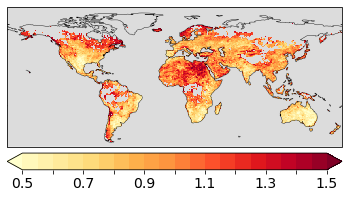

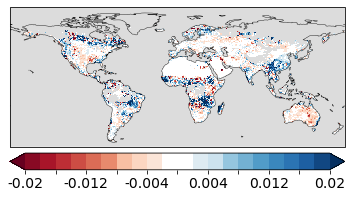

In [38]:
# load anomalies of soil moisture
mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
sm1 = mod.SWVL1 

mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
sm2 = mod.SWVL1 

sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018-stdia_anomalies.nc')
sm_esa=sm_esa.sm
# we need to mask for temporal coverage of esa data
mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018-ia_anomalies_60mask.nc')#mask for 60%ts coverage
mask=mask.sm[72:]
sm_esa = sm_esa.where(mask.notnull())

rmse1 = LE_rmse(sm1,sm_esa)
rmse2 = LE_rmse(sm2,sm_esa)
rmsed = rmse1-rmse2

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0.5,1.5,21)
lvls2= np.linspace(0.5,1.5,11)
tl=['0.5','','0.7','','0.9','','1.1','','1.3','','1.5']
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl)
# ax.set_title('RMSE $\mathrm{SM_s}$ std-anomaly '+str(name1),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmse_sms_stdanomaly_{start_year}_{end_year}_{exp_name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

lvls= np.linspace(-0.02,0.02,21)
lvls2= np.linspace(-0.02,0.02,11)
tl=['-0.02','','-0.012','','-0.004','','0.004','','0.012','','0.02']
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl)
# ax.set_title('$\Delta$RMSE $\mathrm{SM_s}$ std-anomaly '+str(name1)+'-'+str(name2),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_sms_stdanomaly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}.jpg',dpi=300,bbox_inches='tight')

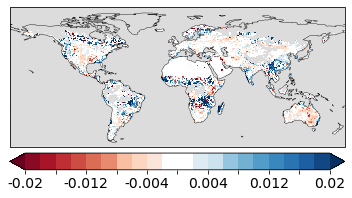

In [39]:
# with sig
dt='dt_no'
start_year = '1999'
end_year = '2018'
reps=1000
tp = f'ia anomalies'
layer='layer1'
th='60'
#load quantiles
tp2 = tp.replace(" ", "_")
q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{start_year}_{end_year}_rmse_{dt}_{th}.nc')

mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
sm1 = mod.SWVL1 

mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
sm2 = mod.SWVL1 

sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018-stdia_anomalies.nc')
sm_esa=sm_esa.sm
# we need to mask for temporal coverage of esa data
mask=xr.open_dataset(f'{fol}/data/ref_data//ESACCI-SOILMOISTURE-1999-2018-ia_anomalies_60mask.nc')#mask for 60%ts coverage
mask=mask.sm[72:]
sm_esa = sm_esa.where(mask.notnull())

r1 = LE_rmse(sm1,sm_esa)
r2 = LE_rmse(sm2,sm_esa)
r = r1-r2

# calculate area percentages of results
cube = r.to_iris()
cube.coord('latitude').guess_bounds()
cube.coord('longitude').guess_bounds()
grid_areas = iris.analysis.cartography.area_weights(cube)

# without significance
r = r.where(r.lat>-60) # exclude antarctica
areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
areas = areas.where(areas.lat>-60) # exclude antarctica
a = areas.where(r.notnull()) # all land points areas with data
asum = a.sum().values # total land area with data

ap = areas.where(r>0) # positive correlation diff - improvement
an = areas.where(r<0) # negative correlation diff - deterioration
ap_p = ap.sum().values/a.sum().values # percentage of +
an_p = an.sum().values/a.sum().values # percentage of -

# with significance
rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
areas = areas.where(areas.lat>-60) # exclude antarctica
a = areas.where(r.notnull()) # all land points areas with data
asum = a.sum().values # total land area with data

asig = areas.where(rs2.notnull()) # all land points areas with data
asigsum = asig.sum().values # total land area with data
asigp = asigsum/asum
aps = areas.where(rs2>0) # positive correlation diff - improvement
ans = areas.where(rs2<0) # negative correlation diff - deterioration
aps_p = aps.sum().values/a.sum().values # percentage of +
ans_p = ans.sum().values/a.sum().values # percentage of -
aps_ps = aps.sum().values/asig.sum().values # percentage of +
ans_ps = ans.sum().values/asig.sum().values # percentage of -

# mean + or - delta correlation
rp = r.where(r>0).mean().values
rn = r.where(r<0).mean().values

rps = rs2.where(rs2>0).mean().values
rns = rs2.where(rs2<0).mean().values

rnull = r.isnull()

lvls = np.linspace(-0.05,0.05,21)
lvls2 = np.linspace(-0.05,0.05,11)
cm2 = plt.cm.get_cmap('Pastel2_r')

lvls= np.linspace(-0.02,0.02,21)
lvls2= np.linspace(-0.02,0.02,11)
tl=['-0.02','','-0.012','','-0.004','','0.004','','0.012','','0.02']
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = r.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl)
# ax.set_title('$\Delta$RMSE $\mathrm{SM_s}$ std-anomaly '+str(name1)+'-'+str(name2),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
# ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=10)
# ax.annotate(f'+ $\Delta$RMSE sig: {np.int(aps_ps*100)}%',(-177,-38), size=10)
# ax.annotate(f'- $\Delta$RMSE sig: {np.int(ans_ps*100)}%',(-177,-55),size=10)
fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_sms_stdanomaly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_sig.jpg',dpi=300,bbox_inches='tight')

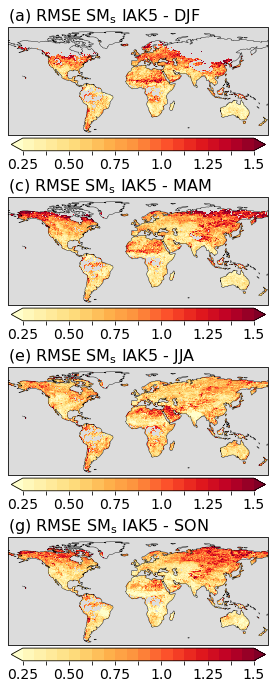

In [40]:
al = ['a','c','e','g']
seasons2=['DJF','MAM','JJA','SON']
seasons=['djf','mam','jja','son']
cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0.5,1.5,21)
lvls2= np.linspace(0.5,1.5,11)
tl=['0.5','','0.7','','0.9','','1.1','','1.3','','1.5']

lvls= np.linspace(0.25,1.5,21)
lvls2= np.linspace(0.25,1.5,11)
tl=['0.25','','0.50','','0.75','','1.0','','1.25','','1.5']

fig = plt.figure(figsize=(24,10))
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
for j in range(len(seasons)):
    mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm1 = mod.SWVL1 

    mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm2 = mod.SWVL1 

    sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018_{seasons[j]}_stdanomalies.nc')
    sm_esa=sm_esa.sm
    
    # we need to mask for temporal coverage of esa data
    mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2019_{seasons[j]}_anomalies_60mask.nc')#mask for 60%ts coverage
    mask=mask.sm
    sm_esa = sm_esa.where(mask.notnull())

    rmse1 = LE_rmse(sm1,sm_esa)
    rmse2 = LE_rmse(sm2,sm_esa)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
    
    cmap = plt.cm.get_cmap('YlOrRd')
    ax = plt.subplot(4,1,j+1,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    n = rmsed.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2,shrink=0.3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl)
    ax.set_title('('+str(al[j])+') RMSE $\mathrm{SM_s}$ '+str(name1)+' - '+str(seasons2[j]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmse_sms_stdanomaly_{start_year}_{end_year}_{exp_name1}_{name1}_seasons.jpg',dpi=300,bbox_inches='tight')

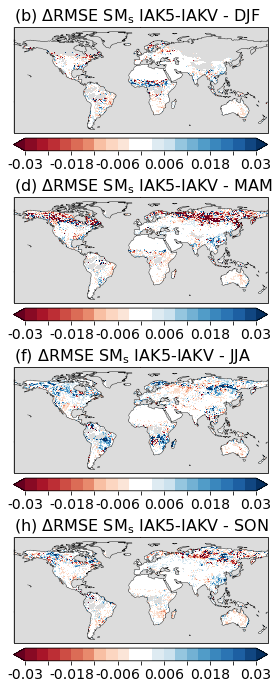

In [41]:
al = ['b','d','f','h']
seasons2=['DJF','MAM','JJA','SON']
seasons=['djf','mam','jja','son']

# lvls= np.linspace(-0.02,0.02,21)
# lvls2= np.linspace(-0.02,0.02,11)
# tl=['-0.04','','-0.024','','-0.008','','0.008','','0.024','','0.04']

lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,11)
tl=['-0.03','','-0.018','','-0.006','','0.006','','0.018','','0.03']

fig = plt.figure(figsize=(24,10))
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
for j in range(len(seasons)):
    mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm1 = mod.SWVL1 

    mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm2 = mod.SWVL1 

    sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018_{seasons[j]}_stdanomalies.nc')
    sm_esa=sm_esa.sm
    
    # we need to mask for temporal coverage of esa data
    mask=xr.open_dataset(f'{fol}/data/ref_data//ESACCI-SOILMOISTURE-1999-2019_{seasons[j]}_anomalies_60mask.nc')#mask for 60%ts coverage
    mask=mask.sm
    sm_esa = sm_esa.where(mask.notnull())

    rmse1 = LE_rmse(sm1,sm_esa)
    rmse2 = LE_rmse(sm2,sm_esa)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
     
    ax = plt.subplot(4,1,j+1,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    n = rmsed.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,shrink=0.3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl)
    ax.set_title('('+str(al[j])+') $\Delta$RMSE $\mathrm{SM_s}$ '+str(name1)+'-'+str(name2)+' - '+str(seasons2[j]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_sms_stdanomaly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_seasons.jpg',dpi=300,bbox_inches='tight')

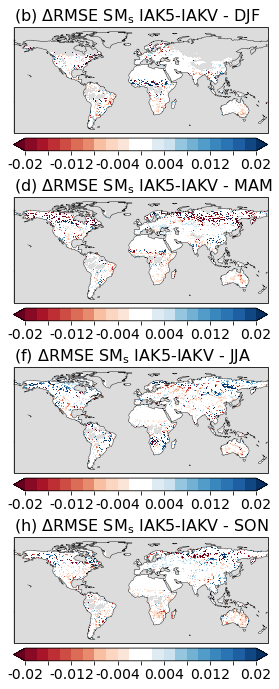

In [42]:
# seasons sig
al = ['b','d','f','h']
seasons2=['DJF','MAM','JJA','SON']
seasons=['djf','mam','jja','son']

lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,11)
tl=['-0.03','','-0.018','','-0.006','','0.006','','0.018','','0.03']

fig = plt.figure(figsize=(24,10))
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.3)
for j in range(len(seasons)):
    start_year = '1999'
    end_year = '2018'
    reps=1000
    tp = f'ia anomalies'
    layer='layer1'
    th='60'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{seasons[j]}_{start_year}_{end_year}_rmse_{dt}_{th}.nc')

    mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm1 = mod.SWVL1 

    mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm2 = mod.SWVL1 

    sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018_{seasons[j]}_stdanomalies.nc')
    sm_esa=sm_esa.sm
    
    # we need to mask for temporal coverage of esa data
    mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2019_{seasons[j]}_anomalies_60mask.nc')#mask for 60%ts coverage
    mask=mask.sm
    sm_esa = sm_esa.where(mask.notnull())

    r1 = LE_rmse(sm1,sm_esa)
    r2 = LE_rmse(sm2,sm_esa)
    r = r1-r2

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()
    
    lvls= np.linspace(-0.02,0.02,21)
    lvls2= np.linspace(-0.02,0.02,11)
    tl=['-0.02','','-0.012','','-0.004','','0.004','','0.012','','0.02']
    
    ax = plt.subplot(4,1,j+1,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    n = r.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,shrink=0.3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl)
    ax.set_title('('+str(al[j])+') $\Delta$RMSE $\mathrm{SM_s}$ '+str(name1)+'-'+str(name2)+' - '+str(seasons2[j]),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=8)
    # ax.annotate(f'+ $\Delta$RMSE sig: {np.int(aps_ps*100)}%',(-177,-38), size=8)
    # ax.annotate(f'- $\Delta$RMSE sig: {np.int(ans_ps*100)}%',(-177,-55),size=8)
fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_sms_stdanomaly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_seasons_sig.jpg',dpi=300,bbox_inches='tight')

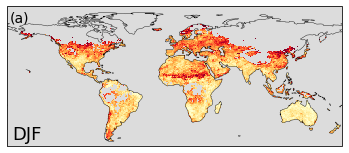

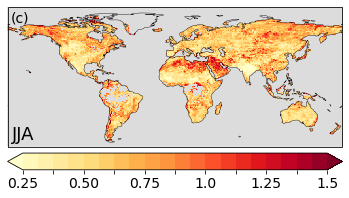

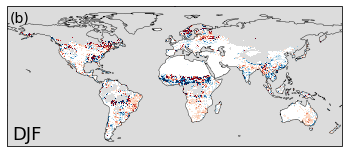

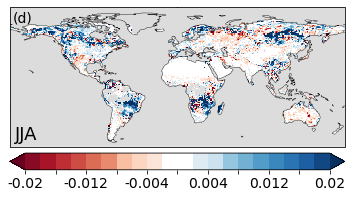

In [43]:
#JJA AND DJF
# JJA AND DJF

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0.25,1.5,21)
lvls2= np.linspace(0.25,1.5,11)
tl=['0.25','','0.50','','0.75','','1.0','','1.25','','1.5']
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','c','e','g']

for j in range(len(seasons)):
    mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm1 = mod.SWVL1 

    mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm2 = mod.SWVL1 

    sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018_{seasons[j]}_stdanomalies.nc')
    sm_esa=sm_esa.sm
    
    # we need to mask for temporal coverage of esa data
    mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2019_{seasons[j]}_anomalies_60mask.nc')#mask for 60%ts coverage
    mask=mask.sm
    sm_esa = sm_esa.where(mask.notnull())

    rmse1 = LE_rmse(sm1,sm_esa)
    rmse2 = LE_rmse(sm2,sm_esa)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
    
    # all months
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    n = rmsed.notnull()
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    if (j==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl)
    # ax.set_title('('+str(al[j])+') RMSE $\mathrm{SM_s}$ '+str(name1)+' - '+str(seasons_up[j]),size=18,loc='left')
    ax.annotate(f'({al[j]})',(-177,74),size=14)
    # ax.annotate(f'{seasons_up[i]}',(148,71),size=18)
    ax.annotate(f'{seasons_up[j]}',(-175,-53),size=18)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/effective_cover/rmse_sms_monthly_{start_year}_{end_year}_{exp_name1}_{name1}_{seasons_up[j]}.jpg',dpi=300,bbox_inches='tight')

lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,11)
tl=['-0.03','','-0.018','','-0.006','','0.006','','0.018','','0.03']
lvls= np.linspace(-0.02,0.02,21)
lvls2= np.linspace(-0.02,0.02,11)
tl=['-0.02','','-0.012','','-0.004','','0.004','','0.012','','0.02']

al = ['b','d','f','h']

for j in range(len(seasons)):
    mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm1 = mod.SWVL1 

    mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm2 = mod.SWVL1 

    sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018_{seasons[j]}_stdanomalies.nc')
    sm_esa=sm_esa.sm
    
    # we need to mask for temporal coverage of esa data
    mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2019_{seasons[j]}_anomalies_60mask.nc')#mask for 60%ts coverage
    mask=mask.sm
    sm_esa = sm_esa.where(mask.notnull())

    rmse1 = LE_rmse(sm1,sm_esa)
    rmse2 = LE_rmse(sm2,sm_esa)
    rmsed = rmse1-rmse2
    rmsed[0,0]=-0.04
    rmsed[0,1]=0.04
    
    # all months
    n = rmsed.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
    if (j==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl)
    ax.annotate(f'({al[j]})',(-177,74),size=14)
    # ax.annotate(f'{seasons_up[i]}',(148,71),size=18)
    ax.annotate(f'{seasons_up[j]}',(-175,-53),size=18)
    # ax.set_title('('+str(al[j])+') $\Delta$RMSE $\mathrm{SM_s}$ '+str(name2)+'-'+str(name1)+' - '+str(seasons_up[j]),size=18,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_sms_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_{seasons_up[j]}.jpg',dpi=300,bbox_inches='tight')


mean <xarray.DataArray ()>
array(-7.820578e-05, dtype=float32)
median <xarray.DataArray ()>
array(0.)
mean <xarray.DataArray ()>
array(0.00190276, dtype=float32)
median <xarray.DataArray ()>
array(8.59647989e-05)


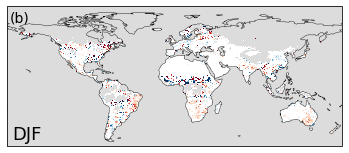

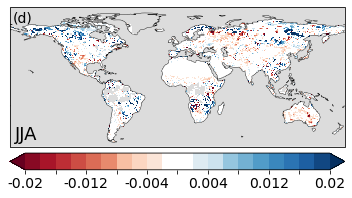

In [44]:
#JJA AND DJF - with sig
# JJA AND DJF

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0.25,1.5,21)
lvls2= np.linspace(0.25,1.5,11)
tl=['0.25','','0.50','','0.75','','1.0','','1.25','','1.5']
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','c']

lvls= np.linspace(-0.02,0.02,21)
lvls2= np.linspace(-0.02,0.02,11)
tl=['-0.02','','-0.012','','-0.004','','0.004','','0.012','','0.02']
al = ['b','d']

for j in range(len(seasons)):
    start_year = '1999'
    end_year = '2018'
    reps=1000
    tp = f'ia anomalies'
    layer='layer1'
    th='60'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{seasons[j]}_{start_year}_{end_year}_rmse_{dt}_{th}.nc')

    mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm1 = mod.SWVL1 

    mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_{seasons[j]}_stdanomalies.nc')
    sm2 = mod.SWVL1 

    sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018_{seasons[j]}_stdanomalies.nc')
    sm_esa=sm_esa.sm
    
    # we need to mask for temporal coverage of esa data
    mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2019_{seasons[j]}_anomalies_60mask.nc')#mask for 60%ts coverage
    mask=mask.sm
    sm_esa = sm_esa.where(mask.notnull())

    r1 = LE_rmse(sm1,sm_esa)
    r2 = LE_rmse(sm2,sm_esa)
    r = r1-r2
    
    print('mean',r.mean())
    print('median',r.median())

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()
    
    # all months
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.4)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (j==1):
        cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    ax.annotate(f'({al[j]})',(-177,74),size=14)
    # ax.annotate(f'{seasons_up[i]}',(148,71),size=18)
    ax.annotate(f'{seasons_up[j]}',(-175,-53),size=18)
    
    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=10)
    # ax.annotate(f'+ $\Delta$RMSE sig: {np.int(aps_ps*100)}%',(-177,-38), size=10)
    # ax.annotate(f'- $\Delta$RMSE sig: {np.int(ans_ps*100)}%',(-177,-55),size=10)
    fig.savefig(f'{fol}/output_figures/effective_cover/rmsediff_sms_monthly_{start_year}_{end_year}_{exp_name1}-{exp_name2}_{name1}-{name2}_{seasons_up[j]}_sig.jpg',dpi=300,bbox_inches='tight')
